In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")

In [3]:
#  유효한 group_id (school_id 존재) 필터
valid_groups = school_df[school_df["school_id"].notnull()]["id"]
active_users = users_df[
    (users_df["created_at"] < "2023-08-01") &
    (users_df["group_id"].isin(valid_groups))
]

In [4]:
#  5–7월 투표 
votes = votes_df[
    (votes_df["created_at"] >= "2023-05-01") &
    (votes_df["created_at"] < "2023-08-01")
].copy()

In [5]:
# 해당 학교 투표 유저만 선별
school_ids = (
    active_users[active_users["id"].isin(votes["user_id"])]
    .merge(school_df.rename(columns={"id":"group_id"})[["group_id","school_id"]], on="group_id", how="left")["school_id"]
    .dropna().unique()
)
target_ids = active_users.merge(
    school_df.rename(columns={"id":"group_id"})[["group_id","school_id"]],
    on="group_id", how="left"
).query("school_id in @school_ids")["id"].unique()
votes = votes[votes["user_id"].isin(target_ids)].copy()

In [6]:
# vote_date, cohort_day, active_day 컬럼 생성
votes["vote_date"] = pd.to_datetime(votes["created_at"]).dt.normalize()
cohort = votes.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")
votes = votes.merge(cohort, on="user_id")
votes["active_day"] = (votes["vote_date"] - votes["cohort_day"]).dt.days
votes = votes[(votes["active_day"] >= 0) &
              (votes["cohort_day"] >= "2023-05-01") &
              (votes["cohort_day"] <= "2023-05-25")]

In [7]:
# cohort_size 및 retained count (nunique 기준)
cohort_size = votes.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")
retained = votes.groupby(["cohort_day", "active_day"])["user_id"].nunique().reset_index(name="retained")


In [8]:
# 리텐션율 계산
ret = retained.merge(cohort_size, on="cohort_day")
ret["rate"] = ret["retained"] / ret["cohort_size"]


In [9]:
# 히트맵용 피벗 (Day 0–10)
heat = ret.pivot(index="cohort_day", columns="active_day", values="rate").fillna(0)
heat_10 = heat.loc[:, :25]


In [10]:
# 5~7월 투표 기록 필터 (이미 target_ids 기준 필터링된 votes 사용)
daily_voters = votes.groupby("vote_date")["user_id"] \
    .nunique().reset_index(name="daily_voter_count")


/tmp/ipykernel_277690/2484358027.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heat_10.applymap(lambda x: f"{x:.1%}")


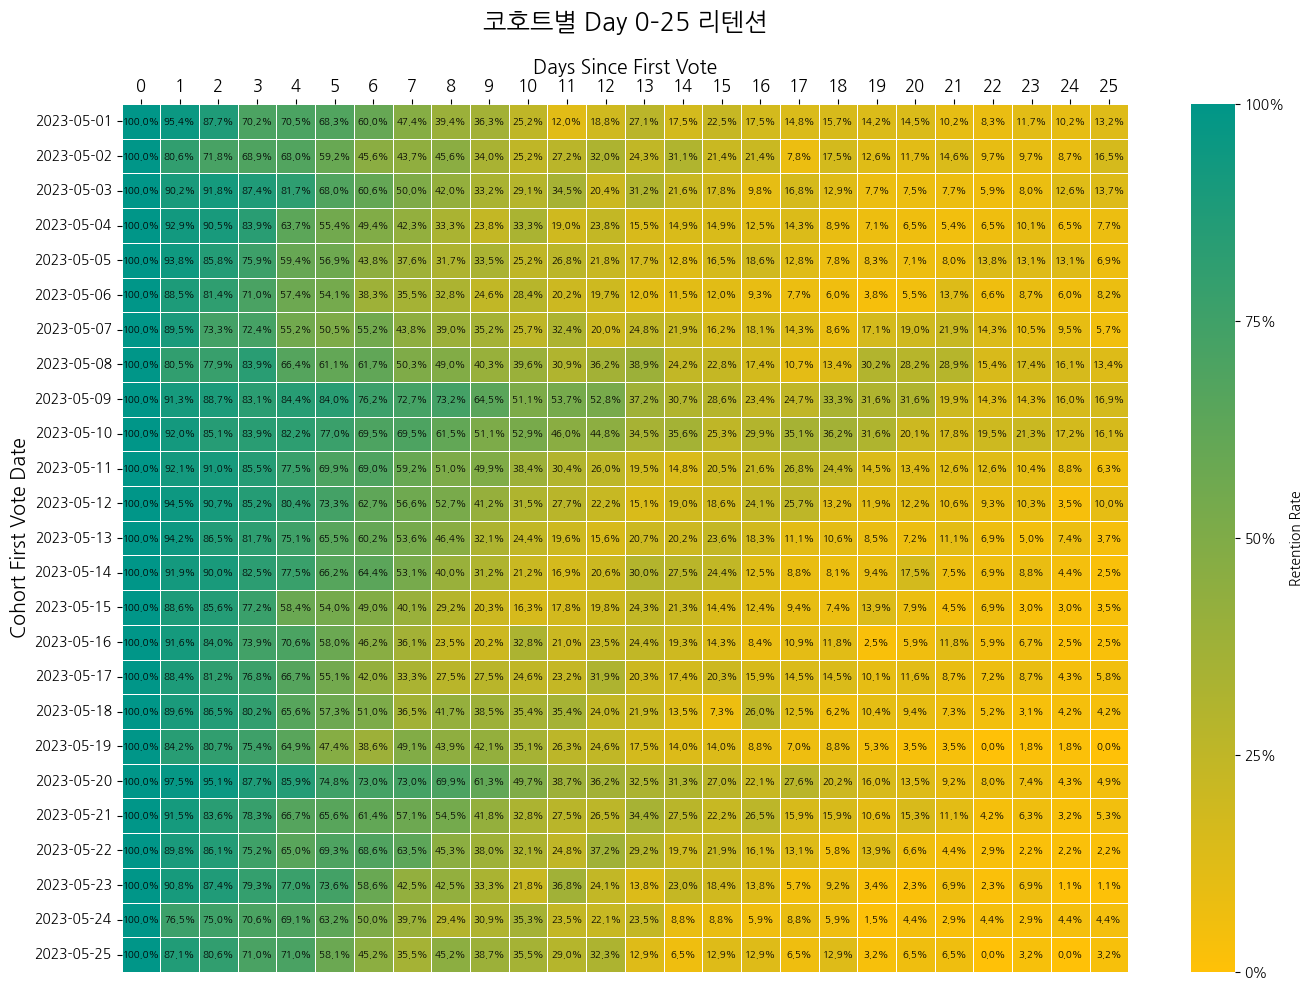

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import ticker

# 컬러맵
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107","#009688"], N=256
)

# annot 포멧팅
annot = heat_10.applymap(lambda x: f"{x:.1%}")

# 히트맵 생성
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heat_10,
    cmap=custom_cmap,
    annot=annot,
    fmt="",
    annot_kws={"size": 7, "color": "black"},
    linewidths=0.5,
    linecolor="white",
    vmin=0, vmax=1,
    cbar_kws={
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, .25, .5, .75, 1]
    }
)

# 축과 레이블 설정
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, fontsize=12)

new_ylabels = [idx.split('T')[0] for idx in heat_10.index.astype(str)]
ax.set_yticklabels(new_ylabels, rotation=0, fontsize=10)

# 타이틀 및 라벨 설정
plt.title("코호트별 Day 0–25 리텐션", fontsize=18, pad=20)
plt.xlabel("Days Since First Vote", fontsize=14)
plt.ylabel("Cohort First Vote Date", fontsize=14)

plt.tight_layout()
plt.show()
